# Exploratory Data Analysis and Visualization
## TV Shows Hosted on Four Streaming Platforms, with IMDB and Rotten Tomatoes Rating
## By: Bryan Kolano, October 28th, 2022
#### Data from [Kaggle Dataset by User: Ruchi Bhatia](https://www.kaggle.com/datasets/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney) 
***

#### Import of packages and reading in the data
I began as a R user in 2017.  I learned about the package "janitor" that has various functionality but I always used to clean up and standardize column names.  Fortunately, there is a python version of the package and it is a very simple way to implement.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import janitor
import math

In [3]:
data = pd.read_csv('tv_shows.csv')

#Get rid of unnecessary columns
df = data.drop(columns=['ID','Unnamed: 0','Type'])

#standardize and clean up names
df = janitor.clean_names(df)
df.head()

,title,year,age,imdb,rotten_tomatoes,netflix,hulu,prime_video,disney+
0,Breaking Bad,2008,18+,9.4/10,100/100,1,0,0,0
1,Stranger Things,2016,16+,8.7/10,96/100,1,0,0,0
2,Attack on Titan,2013,18+,9.0/10,95/100,1,1,0,0
3,Better Call Saul,2015,18+,8.8/10,94/100,1,0,0,0
4,Dark,2017,16+,8.8/10,93/100,1,0,0,0


#### Basic Exploratory Data Analysis to understand the data better

In [4]:
df.describe()

,year,netflix,hulu,prime_video,disney+
count,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000
mean,2012.628726,0.367176,0.301975,0.341095,0.065387
std,10.142813,0.482080,0.459157,0.474122,0.247231
min,1904.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,0.000000,0.000000,0.000000,0.000000
50%,2016.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,1.000000,1.000000,1.000000,0.000000
max,2021.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#check out number of shows by debut year
df['year'].value_counts().head(30)

2017    605
2018    562
2019    500
2020    489
2016    486
2015    348
2014    261
2013    231
2012    230
2021    224
2011    189
2010    161
2009    120
2008     91
2005     78
2007     77
2006     73
2004     58
2003     46
2001     41
2002     41
1998     35
1999     34
2000     34
1997     25
1996     23
1994     22
1993     21
1995     16
1989     16
Name: year, dtype: int64

In [6]:
#check out shows by age ratings
df['age'].value_counts()

16+    995
18+    854
7+     831
all    552
13+      9
Name: age, dtype: int64

In [7]:
#how many streaming shows are on each platform?
platforms = ['netflix','hulu','prime_video','disney+']

for plat in platforms:
    print(f"There are {df[plat].sum()} shows on {plat.capitalize()}.")

There are 1971 shows on Netflix.
There are 1621 shows on Hulu.
There are 1831 shows on Prime_video.
There are 351 shows on Disney+.


#### Data cleaning and function development for visualization analysis
1. The raw dataset had a few columns that needed to cleaned.  For example, IMDB ratings were not a number, but rather a rating out of 10, like 9/10 or 7.5/ 10 for example.  <br> The Rotten Tomatoes (RT) column was similar, with ratings our of 100, like 95/100. <br>

2. Ratings were stripped from the ratings columns and put into new columns. <br>
3. Additionally, to be able to use both IMDB and RT rating, IMDB ratings were scaled to 100 and then averages with the RT ratings, in the "rating_combined" column.
4. The function "best_shows" takes in the data and returns the top 10 shows based on average IMDB and RT rating.  Additionally, there are optional inputs that allow you to select a particular streaming platform and/or select a particular year.

In [8]:
#cut out IMDB values and Rotten tomatoes values to make them floats 
#as opposed to ratings like 9/10

df['imdb_raw'] = df['imdb'].str.split('/').str[0]
df['rotten_raw'] = df['rotten_tomatoes'].str.split('/').str[0]

df = df.astype(
    {'imdb_raw':'float',
    'rotten_raw': 'float'}
)

#Combine the ratings to find average ratings across the two
#Since they are on different scales, convert imdb_rating to a number out of 100

df['rating_combined'] = ((df['imdb_raw'] *10) + df['rotten_raw'])/2

df.fillna(0, inplace = True)
df.head()

,title,year,age,imdb,rotten_tomatoes,netflix,hulu,prime_video,disney+,imdb_raw,rotten_raw,rating_combined
0,Breaking Bad,2008,18+,9.4/10,100/100,1,0,0,0,9.4,100.0,97.0
1,Stranger Things,2016,16+,8.7/10,96/100,1,0,0,0,8.7,96.0,91.5
2,Attack on Titan,2013,18+,9.0/10,95/100,1,1,0,0,9.0,95.0,92.5
3,Better Call Saul,2015,18+,8.8/10,94/100,1,0,0,0,8.8,94.0,91.0
4,Dark,2017,16+,8.8/10,93/100,1,0,0,0,8.8,93.0,90.5


In [9]:
#write a function that will take in the dataset, and can optionally a particular streaming platform
# can also optionally take a year.

def best_shows(data, platform = "", year = None):
    
    if (platform != "") and (year is not None):
        current = (data
            .loc[lambda x: x[platform] == 1]
            .loc[lambda x: x['year'] == year]
                  )
        current  = current.sort_values(by = 'rating_combined', ascending = False).head(10)
        
    elif (platform == "") and (year is not None):
        current = (data
            .loc[lambda x: x['year'] == year]
                  )
        current  = current.sort_values(by = 'rating_combined', ascending = False).head(10)
        
    elif (platform != "") and (year is None) :
        current = (data
            .loc[lambda x: x[platform] == 1]
                  )
        current  = current.sort_values(by = 'rating_combined', ascending = False).head(10)
        
    elif (platform == "") and (year is None) :
        current  = data.sort_values(by = 'rating_combined', ascending = False).head(10)
        
    return current

#### Visualization of the Data

##### The best shows 
The first grouping of graphic show the highest rated show, by streaming platform.  There are some shows that are on multiple streaming platforms. For example, "Avatar: The Last Airbender" is rated in the top 10 of shows on Netflix and Amazon Prime.

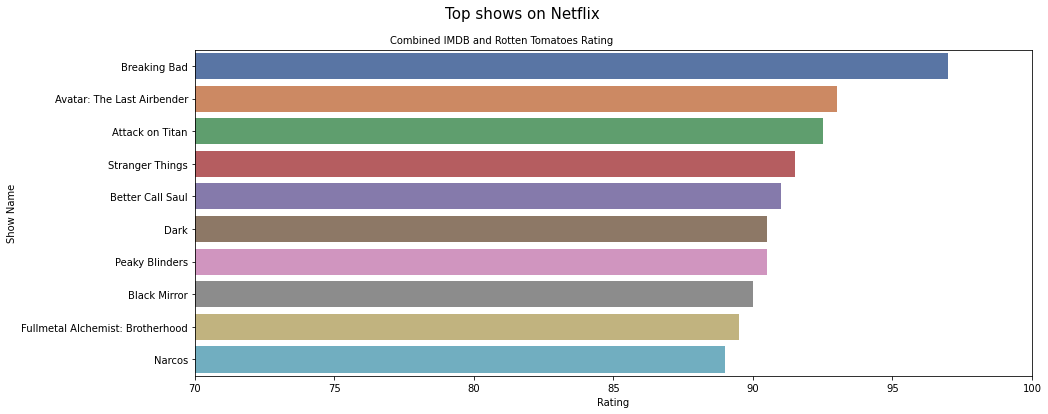

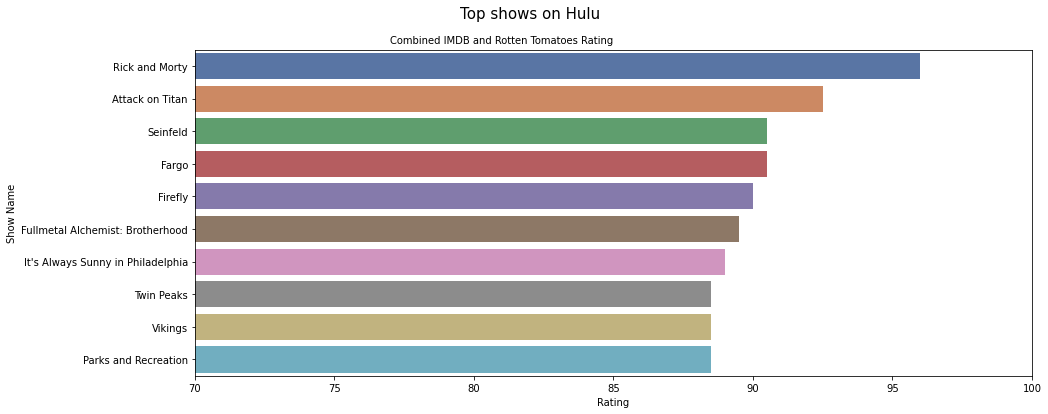

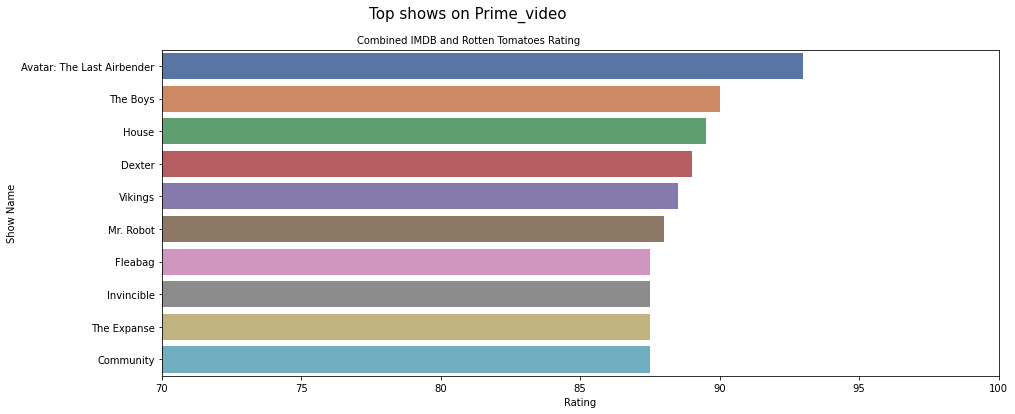

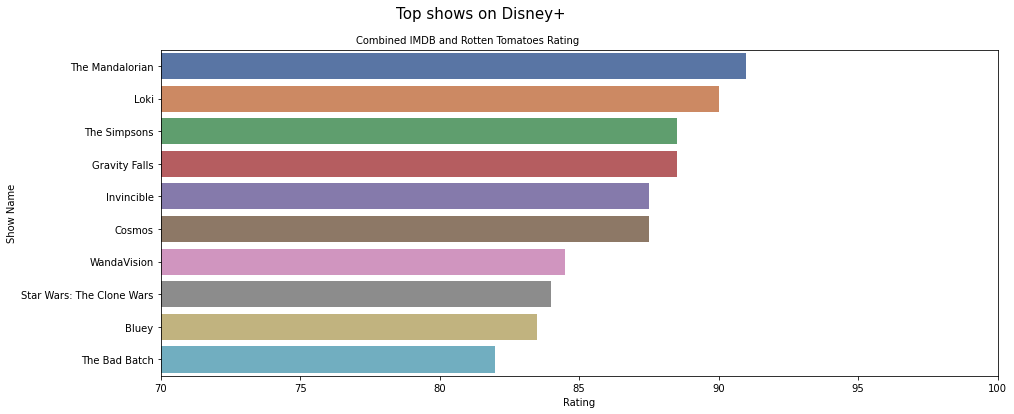

In [10]:
#top shows on each platform

for plat in platforms:
    plt.figure(figsize=(15,6))
    sns.barplot(data = best_shows(df, platform= plat), y = 'title', x = 'rating_combined', palette= 'deep')
    
    plt.xlim(70,100)
    plt.xlabel('Rating')
    plt.ylabel('Show Name')
    # plt.title(f'Top shows on {plat.capitalize()}',fontsize=15, ha = 'left')
    plt.suptitle(f'Top shows on {plat.capitalize()}',fontsize=15, ha = 'right')
    plt.title('Combined IMDB and Rotten Tomatoes Rating', fontsize = 10, ha = 'right')

In many visualizations, when x axis labels are long text, the easiest ways to deal with that is to flip the axes, like the graphs above, or rate the text to be oriented on 90 degrees.  Even when labels are rotated 90 degrees, some of the show titles are quite long, like "It's always sunny in Philadelphia".  Even rotated 90 degrees means, the two graphs below would be really far below the top two because of this long title.  
<br>
To deal with this, I wrote a little bit of code that took names with more than two words and split them across two lines to make the four graphs appear more aesthetic. <br>

To take advantange of this name spliting rotation on the x axis, I created two graphics to better understand the data:
1. Top 10-rated shows by each platform.
2. Top 10-rated shows across all platforms, by debut year, from 1999-2020.

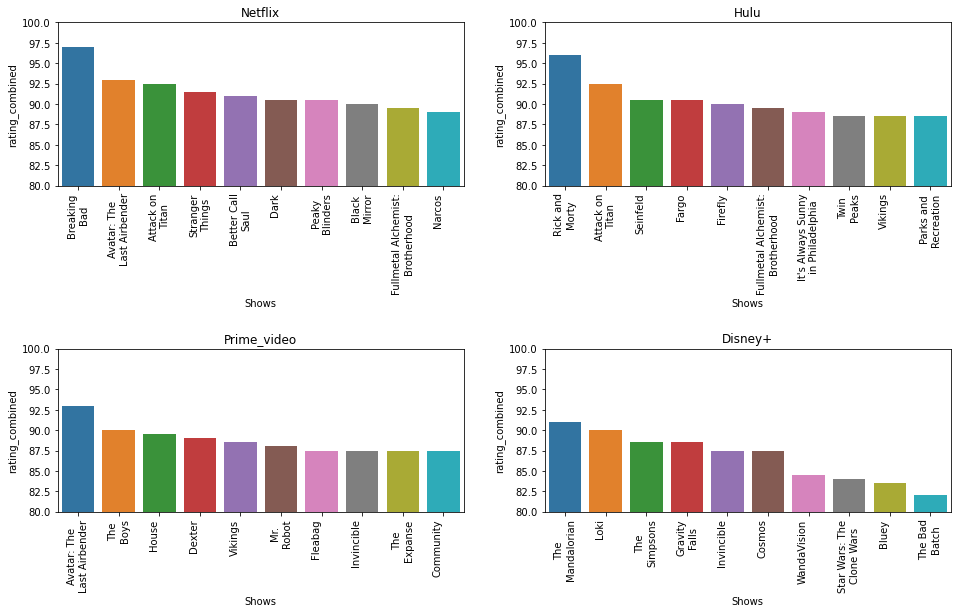

In [11]:
#Top shows across each platform

platforms = ['netflix','hulu','prime_video','disney+']
    
fig, axs = plt.subplots(2,2, figsize = (16, 9))

fig.subplots_adjust(hspace=1)
#plt.xticks(wrap = True)

for platform,ax in zip(platforms, axs.ravel()):
    sns.barplot(data = best_shows(df,platform), x = 'title', y = 'rating_combined', ax = ax)    
    ax.set_ylim(80,100)
    ax.set_title(platform.capitalize())
    ax.set_xlabel('Shows')
    ax.xaxis.set_tick_params(rotation=90)
    
    #These next lines of codes are to take in a given label, and if it is greater than two
    #words long, then it'll break it in half (if even number of words in title) or close to half (if
    # odd number of words in title) and then puts a line break in each label
    labels = [item.get_text() for item in ax.get_xticklabels()]
    split_labels = []
    for x in labels:
        x = x.split()
        if len(x) % 2 == 0 and len(x) > 2:
            a = ' '.join(x[:(int((len(x)/2)))])
            b = ' '.join(x[int((len(x)/2)):])
        else:
            a = ' '.join(x[:math.ceil(len(x)/2)])
            b = ' '.join(x[math.ceil(len(x)/2):])
        hold = '\n'.join([a,b])
        split_labels.append(hold)
        
    ax.set_xticklabels(labels = split_labels)
    #plt.xticks(wrap = True)

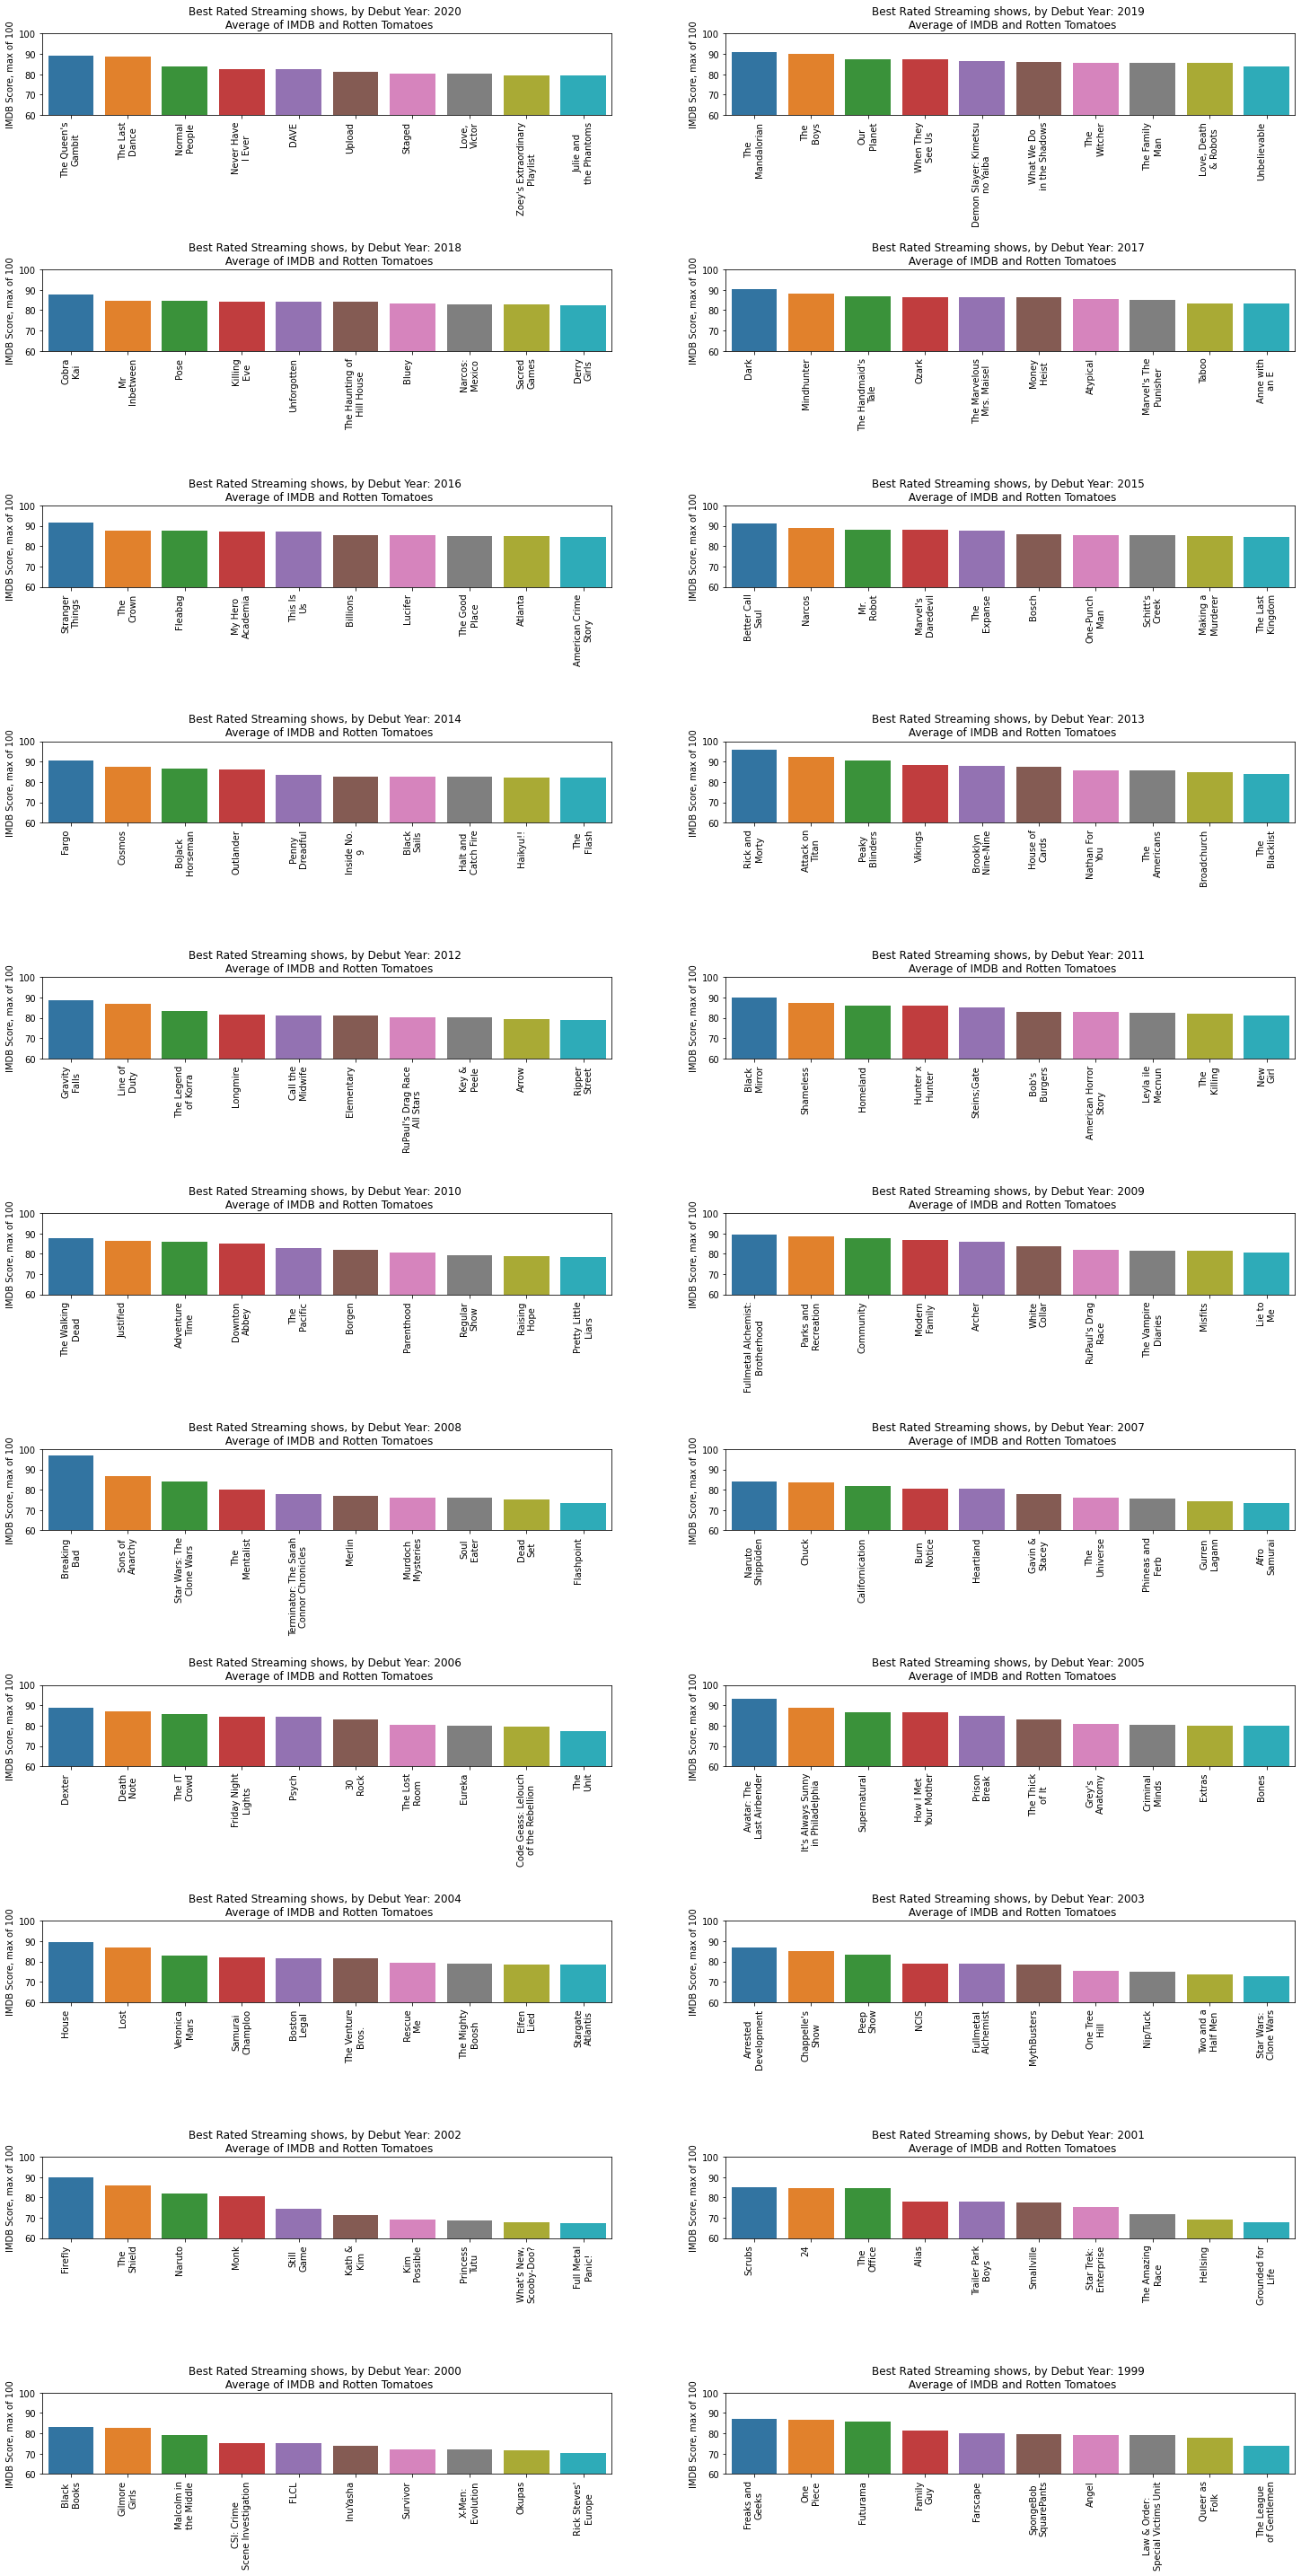

In [12]:
#best shows by year, IMDB and rotten tomatoes average
years = [year for year in range(1999,2021)]
years = list(reversed(years))

fig, axs = plt.subplots(ncols= 2, nrows = 11, figsize = (25, 50))

for year,ax in zip(years, axs.ravel()):
    fig.subplots_adjust(hspace= 1.9)
    #print(f'year {year}, ax {ax}')
    #sns.barplot(data = best_shows(df,platform), x = 'title', y = 'rating_combined', ax = ax)    
    current_year_df = df[df['year'] == year]
    current_year_df = current_year_df.sort_values(by = 'rating_combined', ascending = False)
    
    sns.barplot(x = 'title', y = 'rating_combined', data= current_year_df.head(10), ax = ax)
    ax.set_xlabel('')
    ax.set_ylabel('IMDB Score, max of 100')
    ax.set_title(f"Best Rated Streaming shows, by Debut Year: {year} \n Average of IMDB and Rotten Tomatoes")
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(60,100)
    
    
    #This label breakdown below does the same thing as the previous code block
    labels = [item.get_text() for item in ax.get_xticklabels()]
    split_labels = []
    for x in labels:
        x = x.split()
        if len(x) % 2 == 0 and len(x) > 2:
            a = ' '.join(x[:(int((len(x)/2)))])
            b = ' '.join(x[int((len(x)/2)):])
        else:
            a = ' '.join(x[:math.ceil(len(x)/2)])
            b = ' '.join(x[math.ceil(len(x)/2):])
        hold = '\n'.join([a,b])
        split_labels.append(hold)
        
    ax.set_xticklabels(labels = split_labels)
    




##### The worst shows
Many of the shows in the data had no rating in IMDB, in RT, or in both.  To account for that, any show that did not have a rating was excluded from this next section.


In [13]:
#Looking at worst shows, need to get rid of shows that don't have ratings on both IMDB and Rotten Tomatoes

df_no_zeros = df.query(
            "imdb_raw != 0 and \
            rotten_raw != 0"
)
df_no_zeros_sorted = df_no_zeros.sort_values(by = 'rating_combined', ascending = True)

The following graph shows the 10 shows across all platforms and years, by average IMDB and RT rating.  The issue I was that have never heard of any of these shows.  I made the assumption that because I have never heard of these poorly-rated shows, some of them had to be before I started watching tv.  <br>

It turns out I was wrong; of the worst rated shows, the oldest one was from 2005.  I have probably not heard of them because they were not advertised due to great reviews, were recommended to me by streaming platforms, or perhaps they didn't last long on each respective platform.

Text(0.5, 1.0, 'Worst T.V. Shows on Streaming Platforms')

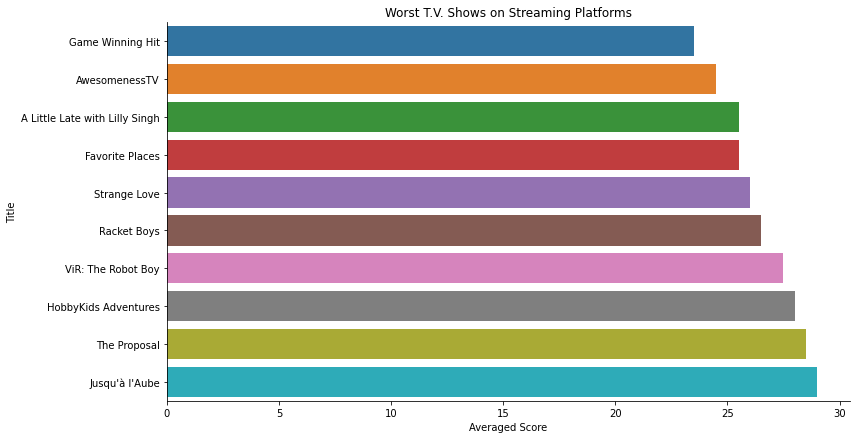

In [14]:
#worst shows across all platforms

g = sns.catplot(x = 'rating_combined', y = 'title', data = df_no_zeros_sorted.head(10), kind = 'bar',height=6, aspect=2)
#plt.xlabel('Title')
g.set_xlabels('Averaged Score')
g.set_ylabels('Title')
plt.title('Worst T.V. Shows on Streaming Platforms')

In [15]:
#what year did these bad TV shows debut?
df_no_zeros_sorted.head(10)[['title','year']]

,title,year
1892,Game Winning Hit,2009
3279,AwesomenessTV,2013
3174,A Little Late with Lilly Singh,2019
4462,Favorite Places,2012
4449,Strange Love,2005
1537,Racket Boys,2021
4459,ViR: The Robot Boy,2013
3243,HobbyKids Adventures,2019
3151,The Proposal,2018
1864,Jusqu'à l'Aube,2020


##### Pivoting the data 

Given the nature of data, where each platform column value was a 1, if a particular platform hosted a particular series and 0 if not, created a few unique problems, given the data was tidy, as defined by [Hadley Wickham](https://r4ds.had.co.nz/tidy-data.html).  In other words, the four platform columns are more like data themselves and shouldn't be across four individual columns.  They should be in one column, and then the values they represent will also create their own column.  <br>

The first way to tidy this data was to create a custom function, and then use that function to define a new column in the dataset called "platform".  Because some shows are on multiple streaming platforms, the function will label those as "multi-platform".

In [16]:
#Convert four platform columns into one column called platform

def platform(a, b, c, d):
    #if more than one platform column has a 1, then call it multi platform
    if sum([a,b,c,d]) > 1:
        return 'multi-platform'
    if a == 1:
        return 'netflix'
    elif b == 1:
        return 'hulu'
    elif c == 1:
        return "prime_video"
    else:
        return 'disney+'

In [17]:

df['platform'] = df.apply(lambda x: platform(x['netflix'], x['hulu'], x['prime_video'], x['disney+']), axis = 1 )
df.head()

,title,year,age,imdb,rotten_tomatoes,netflix,hulu,prime_video,disney+,imdb_raw,rotten_raw,rating_combined,platform
0,Breaking Bad,2008,18+,9.4/10,100/100,1,0,0,0,9.4,100.0,97.0,netflix
1,Stranger Things,2016,16+,8.7/10,96/100,1,0,0,0,8.7,96.0,91.5,netflix
2,Attack on Titan,2013,18+,9.0/10,95/100,1,1,0,0,9.0,95.0,92.5,multi-platform
3,Better Call Saul,2015,18+,8.8/10,94/100,1,0,0,0,8.8,94.0,91.0,netflix
4,Dark,2017,16+,8.8/10,93/100,1,0,0,0,8.8,93.0,90.5,netflix


I was curious to see if certain streaming platform hosted higher rated shows compared to other platforms.  As I scrolled through the data, I saw numerous highly rated shows on netflix compared to the other platforms.  Howver, when graphically depicted, across the four platforms it appears as though none have better-rated shows than others, the medians of each are in the mid to high 60s. <br>

Since I saw so many highly-ranked Netflix-hosted shows, but all the platforms are fairly comparable in terms of rankings, this leads me to believe that even though Netflix has many highly-received shows, they also probably host a bunch of whoppers.


The interesting piece in this box plot is that multi-platform shows are generally higher rated than single platform shows.  This makes sense: if a show is successful, it's probably more likely another platform will want to host it as well.

In [18]:
df_no_zeros = df.query(
            "imdb_raw != 0 and \
            rotten_raw != 0"
)

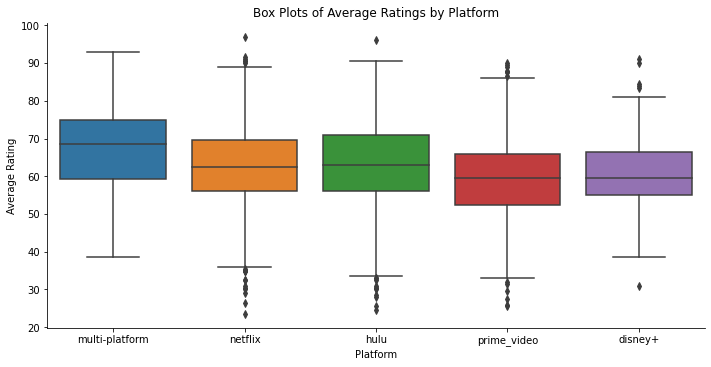

In [19]:
#what platforms have shows with the best ratings overall?
order = ['multi-platform', 'netflix','hulu','prime_video','disney+']

g = sns.catplot(data=df_no_zeros, x="platform", y="rating_combined", kind="box", 
                height= 5, aspect= 2, order = order)
g.set(title = 'Box Plots of Average Ratings by Platform',
       ylabel = 'Average Rating',
     xlabel = "Platform")

The custom function worked for the purpose it served, but both DPLYR in R and Pandas in Python have functions/ methods to pivot data longer or wider, whatever is needed to make it tidy, the melt method of Pandas is used to pivot longer the data.  This produces a similar output to the custom function, but there is no longer a 'multi-platform' value.  Shows on multiple platforms are counted in each of the platforms that hosts them.   

In [20]:
#unpivot
df_longer = pd.melt(df, id_vars=['title','imdb_raw','rotten_raw','rating_combined'], value_vars= ['netflix','hulu','prime_video','disney+'])
df_longer.head()

,title,imdb_raw,rotten_raw,rating_combined,variable,value
0,Breaking Bad,9.4,100.0,97.0,netflix,1
1,Stranger Things,8.7,96.0,91.5,netflix,1
2,Attack on Titan,9.0,95.0,92.5,netflix,1
3,Better Call Saul,8.8,94.0,91.0,netflix,1
4,Dark,8.8,93.0,90.5,netflix,1


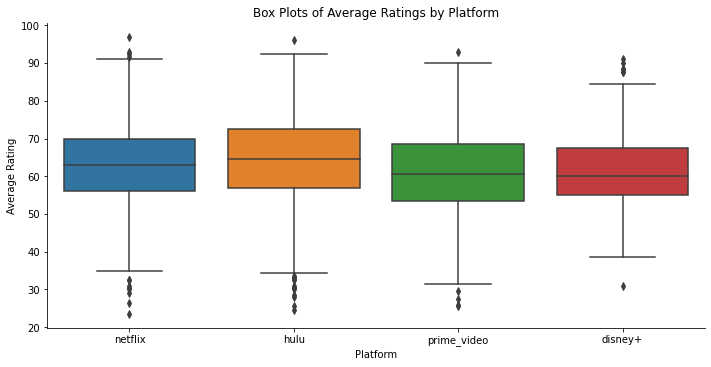

In [21]:
g = sns.catplot(data=df_longer.query("rating_combined > 0 and value == 1"), x="variable", y="rating_combined", kind="box", height= 5, aspect= 2)
g.set(title = 'Box Plots of Average Ratings by Platform',
       ylabel = 'Average Rating',
     xlabel = "Platform")

#### Conclusion
There is some interesting research that can be done by visualization and graphically inspecting the data.  One thing the data lacks is the number of years the show ran, and the years is has been hosted in a given platform.  For example, in this data, a show that debuted in 2008 might be popular in 2009 than any show that debuted in 2009.  However, when we look at top shows in 2009, we won't see that show that debuted in '08, only those that debuted in 2009.  This could be potentially confusing when visually inspecting the results and the graphics.